In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import os

os.chdir('/Users/quinnmackay/Documents/GitHub/BICC/Data Storage/NGRIP/Density files')

In [2]:
shallow_min = 0
bridge_min = 11
central_min = 13
end_min = 100

In [3]:
#importing

#JP Legacy GRIP Shallow Core
grip1 = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Data Storage/GRIP/GRIP1991shallow_density.txt',skiprows=6, header=None)
grip1.rename(columns={0: 'depth'}, inplace=True)
grip1.rename(columns={1: 'density'}, inplace=True)

#Jakob Spline Fit
ngrip1 = pd.read_csv('ng1mbp01.txt',skiprows=26, sep=r'\s+')
ngrip1.rename(columns={'DEPTH(m)': 'depth'}, inplace=True)
ngrip1.rename(columns={'Density': 'density'}, inplace=True)

#NGRIP1 Main Core
ngrip2 = pd.read_excel('NG96DEN.xls',skiprows=6, usecols=[3,6])
ngrip2.rename(columns={'Depth at bottom of bag (m)': 'depth'}, inplace=True)
ngrip2.rename(columns={'Density of bag (kg/m3)': 'density'}, inplace=True)

#2001 Shallow Core
ngrip3 = pd.read_csv('NGRIP_2001_S5_density.txt', skiprows=2, delimiter='\t')

#S4 from Dr. Kawamura
ngrip4 = pd.read_excel('firn data NGRIP2001/NGRPdens.xls', sheet_name=0, skiprows=5, header=None, usecols=[0,5])
ngrip4.rename(columns={0: 'depth'}, inplace=True)
ngrip4.rename(columns={5: 'density'}, inplace=True)

#S5 from Dr. Kawamura
ngrip5 = pd.read_excel('firn data NGRIP2001/NGRPdens.xls', sheet_name=1, skiprows=4, header=None, usecols=[0,5])
ngrip5.rename(columns={0: 'depth'}, inplace=True)
ngrip5.rename(columns={5: 'density'}, inplace=True)

#Kenji S2? Using MEAN depth
ngrip6 = pd.read_excel('NG97S2Density.xlsx', sheet_name=0, skiprows=2, usecols=[3,11], header=None)
ngrip6.rename(columns={3: 'depth'}, inplace=True)
ngrip6.rename(columns={11: 'density'}, inplace=True)
ngrip6

/opt/miniconda3/envs/bicc/lib/python3.13/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,depth,density
0,1.79000,0.346096
1,2.42500,0.345778
2,2.90650,0.384213
3,3.26650,0.367351
4,3.72150,0.372722
...,...,...
244,138.08300,0.895170
245,138.23100,0.880701
246,138.43275,0.891083
247,138.61475,0.888203


Text(0, 0.5, 'Relative Density')

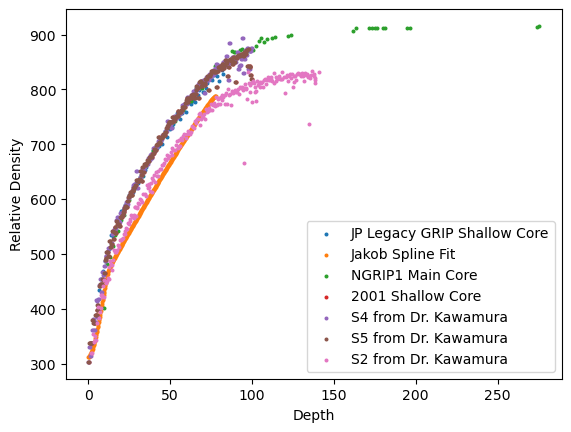

In [4]:
#creating plot

ice_dens = 921
size=3.5

plt.scatter(grip1['depth'], grip1['density'], label="JP Legacy GRIP Shallow Core", s=size)
plt.scatter(ngrip1['depth'], ngrip1['density']*ice_dens, label='Jakob Spline Fit', s=size)
plt.scatter(ngrip2['depth'], ngrip2['density'], label='NGRIP1 Main Core', s=size)
plt.scatter(ngrip3['depth'], ngrip3['density'], label='2001 Shallow Core', s=size)
plt.scatter(ngrip4['depth'], ngrip4['density'], label='S4 from Dr. Kawamura', s=size)
plt.scatter(ngrip5['depth'], ngrip5['density'], label='S5 from Dr. Kawamura', s=size)
plt.scatter(ngrip6['depth'], ngrip6['density']*ice_dens, label='S2 from Dr. Kawamura', s=size)

plt.legend()
plt.xlabel('Depth')
plt.ylabel('Relative Density')
#plt.xlim(25,40)
#plt.ylim(0.3,0.8)

In [5]:
#manually trim positive outliers

ngrip4 = pd.read_excel('firn data NGRIP2001/NGRPdens.xls', sheet_name=0, skiprows=5, header=None, usecols=[0,5])
ngrip4.rename(columns={0: 'depth'}, inplace=True)
ngrip4.rename(columns={5: 'density'}, inplace=True)

indexes = [312,313,342,343,106,107]
ngrip4['density'][indexes] = np.nan

ngrip4 = ngrip4.dropna(subset=['density'])
ngrip4 = ngrip4.reset_index(drop=True)

/var/folders/cd/1mh45k3j19g5g_kxkz_17xvc0000gn/T/ipykernel_1409/2812083537.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ngrip4['density'][indexes] = np.nan


In [6]:
#let's go by 0.2 at a time and filter out low data by a 5 density constraint

#0.2 spacing
intervals = np.arange(0,125.2+0.2,0.15)

dfs = [grip1, ngrip2, ngrip3, ngrip4, ngrip5]
combined_data = pd.concat(dfs, ignore_index=True)

#organize
combined_data = combined_data.sort_values(by='depth', ascending=True)

for i in range(len(intervals)):
    if i == 0:
        continue
    mask = (combined_data['depth'] < intervals[i]) & (combined_data['depth'] >= intervals[i - 1])
    maximum_val = np.max(combined_data[mask]['density'])
    if pd.isna(maximum_val):
        continue
    minimum_allowed = maximum_val - 5

    combined_mask = mask & (combined_data['density'] < minimum_allowed)
    combined_data.loc[combined_mask, 'density'] = np.nan

    combined_data = combined_data.dropna(subset=['density'])



(0.0, 100.0)

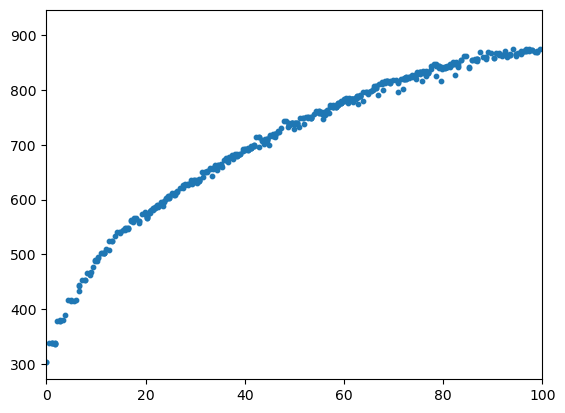

In [7]:
#plot for visualizing sections

#combined_data = pd.concat(dfs, ignore_index=True)
plt.scatter(combined_data['depth'], combined_data['density'], s=10)
plt.xlim(0,100)
#plt.ylim(450,600)

In [8]:
from numpy import polyfit, poly1d

#linear shallow section
mask = (combined_data['depth']>shallow_min) & (combined_data['depth']<=bridge_min)
z_shallow = combined_data['depth'][mask]
rho_shallow = combined_data['density'][mask]
p_shallow = polyfit(z_shallow, rho_shallow, 1)  # linear
rho_fit_shallow = poly1d(p_shallow)


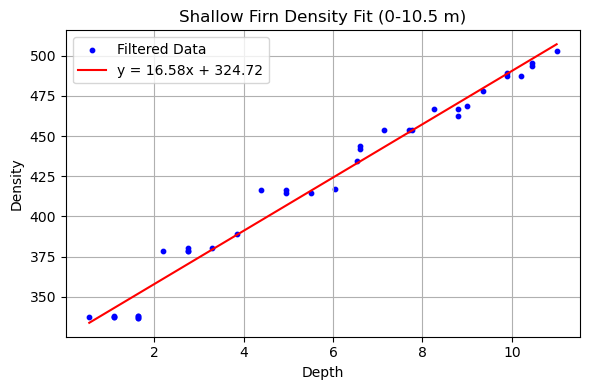

In [9]:
#shallow plot

plt.figure(figsize=(6, 4))
plt.scatter(z_shallow, rho_shallow, label='Filtered Data', color='blue', s=10)
plt.plot(z_shallow, rho_fit_shallow(z_shallow), label=f'y = {np.round(p_shallow[0],2)}x + {np.round(p_shallow[1],2)}', color='red')
plt.xlabel('Depth')
plt.ylabel('Density')
plt.title('Shallow Firn Density Fit (0-10.5 m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
#central section
mask = (combined_data['depth']>central_min) & (combined_data['depth']<=end_min)
z_central = combined_data['depth'][mask]
rho_central = combined_data['density'][mask]
p_central = polyfit(z_central, rho_central, 3)  # linear
rho_fit_central = poly1d(p_central)

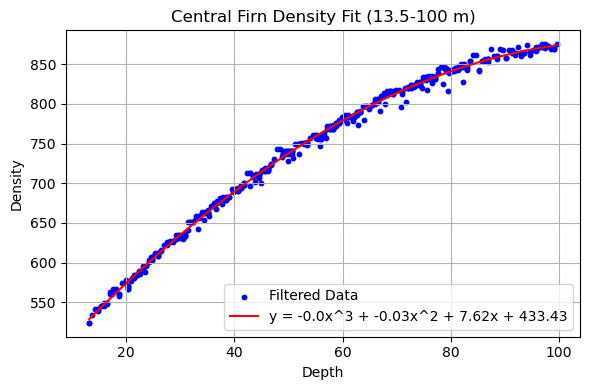

In [11]:
plt.figure(figsize=(6, 4))
plt.scatter(z_central, rho_central, label='Filtered Data', color='blue', s=10)
plt.plot(z_central, rho_fit_central(z_central), label=f'y = {np.round(p_central[0],2)}x^3 + {np.round(p_central[1],2)}x^2 + {np.round(p_central[2],2)}x + {np.round(p_central[3],2)}', color='red')
plt.xlabel('Depth')
plt.ylabel('Density')
plt.title('Central Firn Density Fit (13.5-100 m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
#bridge section

from numpy.linalg import solve

#boundaries
z1 = bridge_min
z2 = central_min

# Get function values and derivatives at z1 and z2
y1 = rho_fit_shallow(z1)
y2 = rho_fit_central(z2)

dy1 = np.polyder(rho_fit_shallow)(z1)
dy2 = np.polyder(rho_fit_central)(z2)

#create bidge polynomial
A = np.array([
    [z1**3, z1**2, z1, 1],
    [z2**3, z2**2, z2, 1],
    [3*z1**2, 2*z1, 1, 0],
    [3*z2**2, 2*z2, 1, 0]
])
b = np.array([y1, y2, dy1, dy2])

# Solve for cubic coefficients
p_bridge = solve(A, b)
rho_fit_bridge = poly1d(p_bridge)

mask = (combined_data['depth']>bridge_min) & (combined_data['depth']<=central_min)
z_bridge = combined_data['depth'][mask]

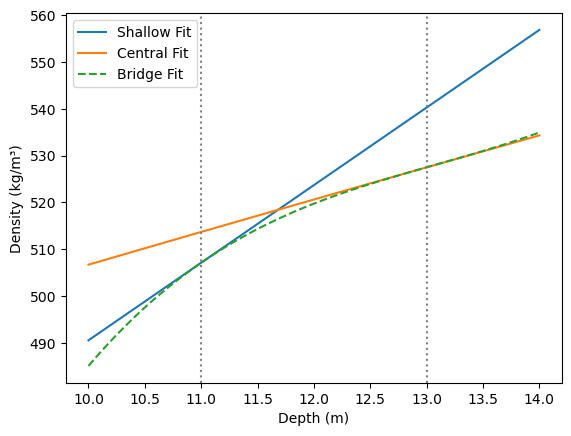

In [13]:
#check fit

z_vals = np.linspace(bridge_min-1, central_min+1, 200)
plt.plot(z_vals, rho_fit_shallow(z_vals), label='Shallow Fit')
plt.plot(z_vals, rho_fit_central(z_vals), label='Central Fit')
plt.plot(z_vals, rho_fit_bridge(z_vals), label='Bridge Fit', linestyle='--')

plt.axvline(z1, color='gray', linestyle=':')
plt.axvline(z2, color='gray', linestyle=':')
plt.xlabel("Depth (m)")
plt.ylabel("Density (kg/m³)")
plt.legend()
plt.show()

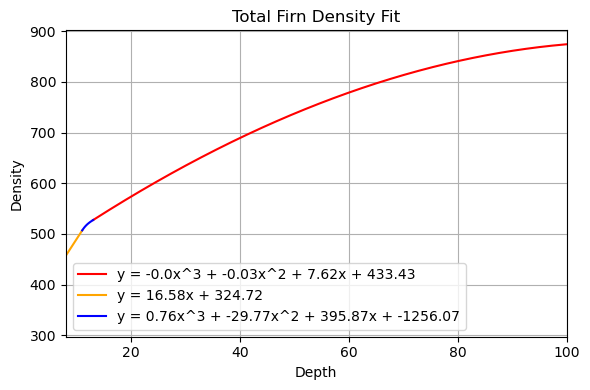

In [14]:
plt.figure(figsize=(6, 4))

z = combined_data['depth']
rho = combined_data['density']

continuous_z_shallow = np.linspace(0,bridge_min,300)
continuous_z_central = np.linspace(central_min,end_min,500)
continuous_z_bridge = np.linspace(bridge_min,central_min,100)

#plt.scatter(z, rho, label='Filtered Data', color='blue', s=10)
plt.plot(continuous_z_central, rho_fit_central(continuous_z_central), label=f'y = {np.round(p_central[0],2)}x^3 + {np.round(p_central[1],2)}x^2 + {np.round(p_central[2],2)}x + {np.round(p_central[3],2)}', color='red')

plt.plot(continuous_z_shallow, rho_fit_shallow(continuous_z_shallow), label=f'y = {np.round(p_shallow[0],2)}x + {np.round(p_shallow[1],2)}', color='orange')

plt.plot(continuous_z_bridge, rho_fit_bridge(continuous_z_bridge), label=f'y = {np.round(p_bridge[0],2)}x^3 + {np.round(p_bridge[1],2)}x^2 + {np.round(p_bridge[2],2)}x + {np.round(p_bridge[3],2)}', color='blue')

plt.xlim(8,100)
plt.xlabel('Depth')
plt.ylabel('Density')
plt.title('Total Firn Density Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
###spline fitting below here